Datengrößen – Gesamt: 64149, Train: 51319, Test (Holdout): 12830

Baseline (Naive Persistence) – Scores:
BL  (Train) MAE:  3.8864
BL  (Train) RMSE: 7.5813
BL  (Train) MAPE: 1,111.87%
BL  (Train) R²:   0.9323
BL  (Test)  MAE:  6.9036
BL  (Test)  RMSE: 8.8074
BL  (Test)  MAPE: 90.58%
BL  (Test)  R²:   0.9107

[ARIMA] Suche nach gutem (p,d,q)...
  Order=(1, 0, 1), MAE=36.7015, Zeit=1.2s


c:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code_Github\masterthesis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  Order=(2, 0, 2), MAE=21.8402, Zeit=14.5s
  Order=(1, 1, 1), MAE=38.4316, Zeit=1.2s
  Order=(2, 1, 1), MAE=38.4380, Zeit=2.5s
[ARIMA] Beste Ordnung laut Val-MAE: (2, 0, 2) (MAE=21.8402)

[ARIMA] Finale Anpassung auf gesamtem Trainingszeitraum...
[ARIMA] Trainings+Forecast-Dauer (Train->Test): 7.5s
ARIMA TST MAE:  41.9997
ARIMA TST RMSE: 50.7393
ARIMA TST MAPE: 101.80%
ARIMA TST R²:   -1.9651

[RF] Hyperparameter-Suche (kleines Grid, erste Optimierung)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[RF] Beste Parameter: {'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}
[RF] Beste CV-MAE: 4.2601
[RF] GridSearch-Dauer: 337.8s
RF TST MAE:  7.0332
RF TST RMSE: 9.0065
RF TST MAPE: 116.76%
RF TST R²:   0.9066

[XGB] Hyperparameter-Suche (kleines Grid, erste Optimierung)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGB] Beste Parameter: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}
[XGB] Beste CV-MAE: 4.3228

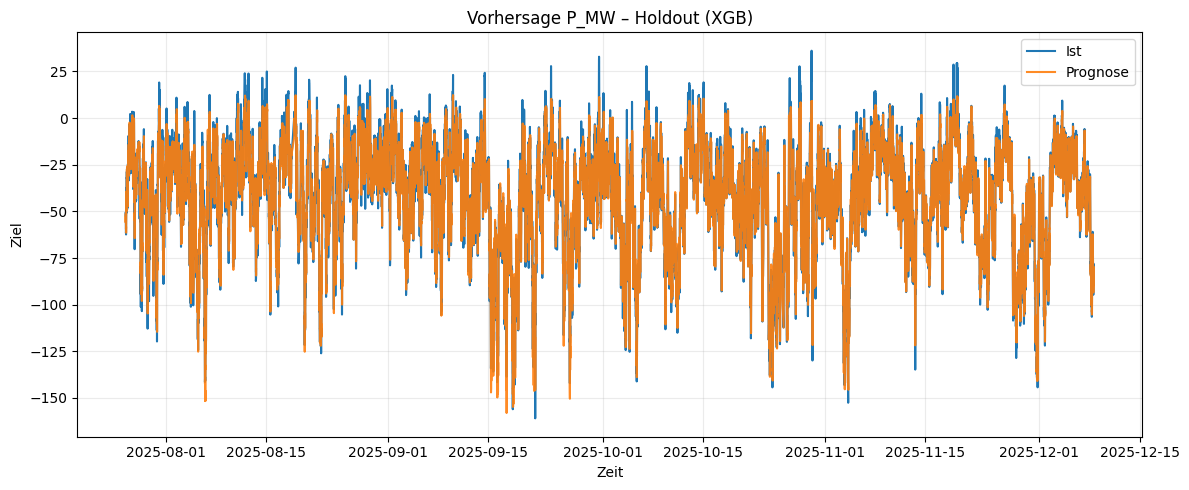


=== Zusammenfassung (Test/Holdout) ===
Baseline: {'MAE': 6.903645806126266, 'RMSE': 8.807377012862911, 'MAPE': np.float64(90.57572110787048), 'R2': 0.9106616714820013}
ARIMA (order=(2, 0, 2)): {'MAE': 41.999657710649224, 'RMSE': 50.7393183193775, 'MAPE': np.float64(101.79737167522443), 'R2': -1.965062856438486}
RF (best_params={'max_depth': 12, 'min_samples_leaf': 10, 'n_estimators': 400}): {'MAE': 7.033172430755622, 'RMSE': 9.006517120050596, 'MAPE': np.float64(116.76468844034382), 'R2': 0.9065760112106608}
XGB (best_params={'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 1.0}): {'MAE': 6.89464827777056, 'RMSE': 8.852117725143435, 'MAPE': np.float64(116.867516118349), 'R2': 0.9097517041202277}
LSTM (best_cfg={'hidden_size': 64, 'dropout': 0.2}): {'MAE': 7.892396231375415, 'RMSE': 10.754569983703192, 'MAPE': np.float64(122.30346007413829), 'R2': 0.8667918649651813}


In [1]:
# -*- coding: utf-8 -*-
"""
Minimal-Setup:
    pip install pandas numpy scikit-learn matplotlib statsmodels xgboost torch
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
from xgboost import XGBRegressor

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# ======= USER-INPUT =======
CSV_PATH = r"src\data\raw\timeseries\SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
CANDIDATE_TARGETS = ["P_MW"]
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (Vielfache von 15 Minuten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]  # 15min, 1h, 2h, 3h, 6h, 24h

# Rolling-Window-Längen (in 15-min-Schritten)
ROLL_WINDOWS = {
    "Windgeschw_mps": [4, 12, 24],
    "Globale_Strahlung_Wm2": [4, 12, 24],
}

# Fourier-Saisonalität (Tagesperiodik = 24h = 96 Schritte à 15min)
FOURIER_K = 3
PERIOD_STEPS = 96  # 24h

HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42

# LSTM-spezifisch (erstes, bewusst einfaches Setup)
LSTM_LOOKBACK = 24   # 24 Schritte (= 6h bei 15min)
LSTM_EPOCHS = 15
LSTM_BATCH_SIZE = 256
LSTM_PATIENCE = 3
LEARNING_RATE = 1e-3
# ==========================

torch.manual_seed(RANDOM_STATE)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)

    target_col = None
    for c in CANDIDATE_TARGETS:
        if c in df.columns:
            target_col = c
            break
    if target_col is None:
        raise KeyError(f"Zielspalte nicht gefunden. Erwartet eine von {CANDIDATE_TARGETS}.")

    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df, target_col


def add_basic_time_features(df, ts_col):
    ts = df[ts_col]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    # Zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps, K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


def add_rolling_features(df, windows_dict):
    for col, wins in windows_dict.items():
        if col not in df.columns:
            continue
        for w in wins:
            df[f"{col}_roll{w}_mean"] = df[col].rolling(window=w, min_periods=w).mean()
            df[f"{col}_roll{w}_std"] = df[col].rolling(window=w, min_periods=w).std()
            df[f"{col}_roll{w}_min"] = df[col].rolling(window=w, min_periods=w).min()
            df[f"{col}_roll{w}_max"] = df[col].rolling(window=w, min_periods=w).max()
    return df


def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_pred, title):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist", linewidth=1.5)
    plt.plot(ts, y_pred, label="Prognose", linewidth=1.5, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit")
    plt.ylabel("Ziel")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


# ===================== ARIMA =====================

def select_arima_order(y_train, candidate_orders):
    n = len(y_train)
    split_idx = int(0.8 * n)
    y_tr = y_train[:split_idx]
    y_val = y_train[split_idx:]

    best_order = None
    best_mae = np.inf

    print("\n[ARIMA] Suche nach gutem (p,d,q)...")
    for order in candidate_orders:
        try:
            start_t = time.time()
            model = sm.tsa.SARIMAX(
                y_tr,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res = model.fit(disp=False)
            val_forecast = res.forecast(steps=len(y_val))
            mae = mean_absolute_error(y_val, val_forecast)
            dur = time.time() - start_t
            print(f"  Order={order}, MAE={mae:.4f}, Zeit={dur:.1f}s")
            if mae < best_mae:
                best_mae = mae
                best_order = order
        except Exception as e:
            print(f"  Order={order} übersprungen (Fehler: {e})")
            continue

    print(f"[ARIMA] Beste Ordnung laut Val-MAE: {best_order} (MAE={best_mae:.4f})")
    return best_order


def run_arima(y_train, y_test):
    candidate_orders = [
        (1, 0, 1),
        (2, 0, 2),
        (1, 1, 1),
        (2, 1, 1),
    ]

    best_order = select_arima_order(y_train, candidate_orders)

    print("\n[ARIMA] Finale Anpassung auf gesamtem Trainingszeitraum...")
    start_t = time.time()
    model = sm.tsa.SARIMAX(
        y_train,
        order=best_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)
    y_pred_test = res.forecast(steps=len(y_test))
    dur = time.time() - start_t
    print(f"[ARIMA] Trainings+Forecast-Dauer (Train->Test): {dur:.1f}s")

    scores = evaluate(y_test, y_pred_test, prefix="ARIMA TST ")
    return scores, best_order, y_pred_test


# ===================== Random Forest & XGBoost =====================

def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (kleines Grid, erste Optimierung)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t
    print(f"[{model_name}] Beste Parameter: {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE: {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch-Dauer: {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST ")
    return scores, grid.best_params_, y_pred_test


# ===================== LSTM (PyTorch) =====================

def create_lstm_dataset(series, lookback):
    """
    Univariate LSTM:
    X_t = [y_{t-lookback}, ..., y_{t-1}], y_t = Ziel.
    """
    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i - lookback:i])
        y.append(series[i])
    X = np.array(X)
    y = np.array(y)
    # Form: (samples, timesteps, features=1)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y


class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # letztes Zeitfenster
        out = self.dropout(out)
        out = self.fc(out)
        return out


def train_lstm_model(
    X_tr,
    y_tr,
    X_val,
    y_val,
    hidden_size,
    dropout,
    epochs=LSTM_EPOCHS,
    batch_size=LSTM_BATCH_SIZE,
):
    X_tr_t = torch.tensor(X_tr, dtype=torch.float32).to(DEVICE)
    y_tr_t = torch.tensor(y_tr, dtype=torch.float32).unsqueeze(-1).to(DEVICE)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1).to(DEVICE)

    train_ds = TensorDataset(X_tr_t, y_tr_t)
    val_ds = TensorDataset(X_val_t, y_val_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = LSTMRegressor(input_size=1, hidden_size=hidden_size, dropout=dropout).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = np.inf
    best_state = None
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        # Early Stopping
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= LSTM_PATIENCE:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_loss


def run_lstm(y_train, y_test, lookback=LSTM_LOOKBACK):
    print("\n[LSTM] Erzeuge Sequenzdaten...")
    y_full = np.concatenate([y_train, y_test])
    X_seq, y_seq = create_lstm_dataset(y_full, lookback)

    n_train = len(y_train)
    last_train_idx = n_train - 1
    train_seq_end = last_train_idx - lookback

    X_train_seq = X_seq[: train_seq_end + 1]
    y_train_seq = y_seq[: train_seq_end + 1]
    X_test_seq = X_seq[train_seq_end + 1:]
    y_test_seq = y_seq[train_seq_end + 1:]

    print(f"[LSTM] Seq-Train: {X_train_seq.shape}, Seq-Test: {X_test_seq.shape}")

    n_seq_train = len(X_train_seq)
    val_split_idx = int(0.8 * n_seq_train)
    X_tr, X_val = X_train_seq[:val_split_idx], X_train_seq[val_split_idx:]
    y_tr, y_val = y_train_seq[:val_split_idx], y_train_seq[val_split_idx:]

    candidate_params = [
        {"hidden_size": 32, "dropout": 0.0},
        {"hidden_size": 64, "dropout": 0.0},
        {"hidden_size": 64, "dropout": 0.2},
    ]

    best_cfg = None
    best_mae = np.inf

    print("[LSTM] Hyperparameter-Suche (hidden_size, dropout)...")
    for cfg in candidate_params:
        print(f"  Teste cfg={cfg} ...")
        start_t = time.time()
        model, best_val_loss = train_lstm_model(
            X_tr,
            y_tr,
            X_val,
            y_val,
            hidden_size=cfg["hidden_size"],
            dropout=cfg["dropout"],
        )
        dur = time.time() - start_t

        model.eval()
        with torch.no_grad():
            X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
            val_pred = model(X_val_t).cpu().numpy().flatten()
        mae = mean_absolute_error(y_val, val_pred)
        print(f"    -> Val-MAE={mae:.4f}, Zeit={dur:.1f}s, best_val_loss={best_val_loss:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_cfg = cfg

    print(f"[LSTM] Beste Konfiguration: {best_cfg}, Val-MAE={best_mae:.4f}")

    # Finale Anpassung auf allen Seq-Train-Daten
    print("[LSTM] Finale Anpassung mit bester Konfiguration...")
    start_t = time.time()
    model, _ = train_lstm_model(
        X_train_seq,
        y_train_seq,
        X_val=X_train_seq[int(0.9 * len(X_train_seq)):],
        y_val=y_train_seq[int(0.9 * len(X_train_seq)):],
        hidden_size=best_cfg["hidden_size"],
        dropout=best_cfg["dropout"],
    )
    dur = time.time() - start_t
    print(f"[LSTM] Trainingsdauer gesamt: {dur:.1f}s")

    model.eval()
    with torch.no_grad():
        X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(DEVICE)
        y_pred_test_seq = model(X_test_t).cpu().numpy().flatten()

    scores = evaluate(y_test_seq, y_pred_test_seq, prefix="LSTM TST ")
    return scores, best_cfg, y_pred_test_seq


# ===================== MAIN =====================

def main():
    df, target_col = load_data(CSV_PATH)

    # Basis-Zeitfeatures + Fourier
    df = add_basic_time_features(df, TIMESTAMP_COL)
    df = add_fourier_features(df, PERIOD_STEPS, FOURIER_K, prefix="day")

    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing:
        print(f"Warnung: fehlen im Datensatz und werden ignoriert: {missing}")

    df = add_rolling_features(df, ROLL_WINDOWS)
    df = add_target_lags(df, target_col, TARGET_LAGS)

    base_time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{target_col}_lag{l}" for l in TARGET_LAGS]
    roll_feats = [c for c in df.columns
                  if any(c.startswith(f"{f}_roll") for f in ROLL_WINDOWS.keys())]

    X_cols = present_feats + base_time_feats + fourier_feats + lag_feats + roll_feats

    df_model = df.dropna(subset=X_cols + [target_col]).copy()

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)
    X = df_model[X_cols]
    y = df_model[target_col]

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test (Holdout): {len(X_test)}")

    # ===== Baseline (Naive: y_hat_t = y_{t-1}) =====
    y_train_baseline = df_model[f"{target_col}_lag1"].iloc[:split_idx].values
    y_test_baseline = df_model[f"{target_col}_lag1"].iloc[split_idx:].values

    print("\nBaseline (Naive Persistence) – Scores:")
    _ = evaluate(y_train.values, y_train_baseline, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_test_baseline, prefix="BL  (Test)  ")

    # ===== ARIMA =====
    arima_scores, arima_order, arima_pred = run_arima(y_train.values, y_test.values)

    # ===== Random Forest =====
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ===== XGBoost =====
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ===== LSTM (PyTorch) =====
    lstm_scores, lstm_best_cfg, lstm_pred = run_lstm(y_train.values, y_test.values)

    # ===== Plot beispielhaft (Holdout: XGB vs Ist) =====
    ts_holdout = df_model[TIMESTAMP_COL].iloc[split_idx:]
    plot_holdout(ts_holdout, y_test.values, xgb_pred, title=f"Vorhersage {target_col} – Holdout (XGB)")

    print("\n=== Zusammenfassung (Test/Holdout) ===")
    print("Baseline:", bl_scores)
    print(f"ARIMA (order={arima_order}):", arima_scores)
    print(f"RF (best_params={rf_best_params}):", rf_scores)
    print(f"XGB (best_params={xgb_best_params}):", xgb_scores)
    print(f"LSTM (best_cfg={lstm_best_cfg}):", lstm_scores)


if __name__ == "__main__":
    main()


In [3]:
# -*- coding: utf-8 -*-
"""
Minimal-Setup:
    pip install pandas numpy scikit-learn matplotlib xgboost torch
"""

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# ======= USER-INPUT =======
CSV_PATH = r"src\data\raw\timeseries\SHUW_E24_hist.csv"
TIMESTAMP_COL = "timestamp"
CANDIDATE_TARGETS = ["P_MW"]

# Achtung: diese Namen müssen zu deiner CSV passen
RAW_FEATURES = ["wind_speed_mps", "solar_radiation_Wm2", "temperature_C"]

# Autoregressive Lags (Vielfache von 15 Minuten)
TARGET_LAGS = [1, 4, 8, 12, 24, 96]  # 15min, 1h, 2h, 3h, 6h, 24h

# Rolling-Window-Längen (in 15-min-Schritten) – Spaltennamen anpassen!
ROLL_WINDOWS = {
    "Windgeschw_mps": [4, 12, 24],
    "Globale_Strahlung_Wm2": [4, 12, 24],
}

# Fourier-Saisonalität (Tagesperiodik = 24h = 96 Schritte à 15min)
FOURIER_K = 3
PERIOD_STEPS = 96  # 24h

# Vorhersagehorizont: 24h = 96 * 15min
HORIZON_STEPS = 96

HOLDOUT_FRAC = 0.2
N_SPLITS = 5
RANDOM_STATE = 42

# LSTM-spezifisch
LSTM_LOOKBACK = 24   # 24 Schritte (= 6h bei 15min)
LSTM_EPOCHS = 15
LSTM_BATCH_SIZE = 256
LSTM_PATIENCE = 3
LEARNING_RATE = 1e-3
# ==========================

torch.manual_seed(RANDOM_STATE)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV nicht gefunden: {path}")
    df = pd.read_csv(path)

    target_col = None
    for c in CANDIDATE_TARGETS:
        if c in df.columns:
            target_col = c
            break
    if target_col is None:
        raise KeyError(f"Zielspalte nicht gefunden. Erwartet eine von {CANDIDATE_TARGETS}.")

    if TIMESTAMP_COL not in df.columns:
        raise KeyError(f"Spalte '{TIMESTAMP_COL}' fehlt in CSV.")

    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=False)
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df, target_col


def add_basic_time_features(df, ts_col):
    ts = df[ts_col]
    df["hour"] = ts.dt.hour
    df["dayofweek"] = ts.dt.dayofweek
    df["month"] = ts.dt.month
    # Zirkuläre Kodierung
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    return df


def add_fourier_features(df, period_steps, K, prefix="day"):
    step_idx = np.arange(len(df), dtype=float) % period_steps
    for k in range(1, K + 1):
        df[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * step_idx / period_steps)
        df[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * step_idx / period_steps)
    return df


def add_target_lags(df, target_col, lags):
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)
    return df


def add_rolling_features(df, windows_dict):
    for col, wins in windows_dict.items():
        if col not in df.columns:
            continue
        for w in wins:
            df[f"{col}_roll{w}_mean"] = df[col].rolling(window=w, min_periods=w).mean()
            df[f"{col}_roll{w}_std"] = df[col].rolling(window=w, min_periods=w).std()
            df[f"{col}_roll{w}_min"] = df[col].rolling(window=w, min_periods=w).min()
            df[f"{col}_roll{w}_max"] = df[col].rolling(window=w, min_periods=w).max()
    return df


def safe_mape(y_true, y_pred, eps=1e-6):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0


def evaluate(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = safe_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MAE:  {mae:,.4f}")
    print(f"{prefix}RMSE: {rmse:,.4f}")
    print(f"{prefix}MAPE: {mape:,.2f}%")
    print(f"{prefix}R²:   {r2:,.4f}")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}


def plot_holdout(ts, y_true, y_pred, title):
    plt.figure(figsize=(12, 5))
    plt.plot(ts, y_true, label="Ist (24h-Ziel)", linewidth=1.5)
    plt.plot(ts, y_pred, label="Prognose (24h)", linewidth=1.5, alpha=0.9)
    plt.title(title)
    plt.xlabel("Zeit (Zielzeitpunkt)")
    plt.ylabel("Leistung [MW]")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


# ===================== Random Forest & XGBoost =====================

def run_tree_model(model_name, base_model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n[{model_name}] Hyperparameter-Suche (GridSearch)...")
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",
        cv=tscv,
        n_jobs=-1,
        verbose=1,
    )
    start_t = time.time()
    grid.fit(X_train, y_train)
    dur = time.time() - start_t
    print(f"[{model_name}] Beste Parameter: {grid.best_params_}")
    print(f"[{model_name}] Beste CV-MAE: {-grid.best_score_:.4f}")
    print(f"[{model_name}] GridSearch+Fit-Dauer: {dur:.1f}s")

    best_model = grid.best_estimator_
    y_pred_test = best_model.predict(X_test)
    scores = evaluate(y_test, y_pred_test, prefix=f"{model_name} TST (24h) ")
    return scores, grid.best_params_, y_pred_test, dur


# ===================== LSTM (PyTorch) =====================

def create_lstm_dataset(series, lookback, horizon_steps):
    """
    Univariate LSTM:
    Eingabe:  [y_{t-lookback}, ..., y_{t-1}]
    Ziel:     y_{t + horizon_steps}
    """
    X, y = [], []
    n = len(series)
    # letzter gültiger Index t: t + horizon_steps < n  → t <= n - horizon_steps - 1
    for t in range(lookback, n - horizon_steps):
        X.append(series[t - lookback:t])
        y.append(series[t + horizon_steps])
    X = np.array(X)
    y = np.array(y)
    # Form: (samples, timesteps, features=1)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y


class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # letztes Zeitfenster
        out = self.dropout(out)
        out = self.fc(out)
        return out


def train_lstm_model(
    X_tr,
    y_tr,
    X_val,
    y_val,
    hidden_size,
    dropout,
    epochs=LSTM_EPOCHS,
    batch_size=LSTM_BATCH_SIZE,
):
    X_tr_t = torch.tensor(X_tr, dtype=torch.float32).to(DEVICE)
    y_tr_t = torch.tensor(y_tr, dtype=torch.float32).unsqueeze(-1).to(DEVICE)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1).to(DEVICE)

    train_ds = TensorDataset(X_tr_t, y_tr_t)
    val_ds = TensorDataset(X_val_t, y_val_t)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = LSTMRegressor(input_size=1, hidden_size=hidden_size, dropout=dropout).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_loss = np.inf
    best_state = None
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        # Early Stopping
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= LSTM_PATIENCE:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_loss


def run_lstm(y_series, split_idx, lookback=LSTM_LOOKBACK, horizon_steps=HORIZON_STEPS):
    """
    y_series: komplette Zeitreihe (Train+Test) als 1D-Array
    split_idx: Index-Grenze Train/Test in Originalzeitreihe (wie in main)
    horizon_steps: Vorhersagehorizont in Schritten (z.B. 96 für 24h)
    """
    print("\n[LSTM] Erzeuge Sequenzdaten (24h-Horizont)...")

    X_seq, y_seq = create_lstm_dataset(y_series, lookback, horizon_steps)
    n_seq = len(y_seq)

    # Zielzeitpunkte pro Sample:
    # t_target = (lookback + i) + horizon_steps
    t_targets = np.arange(lookback, lookback + n_seq) + horizon_steps

    # Train-Samples: Zielzeitpunkt in Trainingsbereich
    train_mask = t_targets < split_idx
    test_mask = t_targets >= split_idx

    X_train_seq = X_seq[train_mask]
    y_train_seq = y_seq[train_mask]
    X_test_seq = X_seq[test_mask]
    y_test_seq = y_seq[test_mask]

    print(f"[LSTM] Seq-Train: {X_train_seq.shape}, Seq-Test: {X_test_seq.shape}")

    # 80/20 Val-Split innerhalb des Trainingsbereichs
    n_seq_train = len(X_train_seq)
    val_split_idx = int(0.8 * n_seq_train)
    X_tr, X_val = X_train_seq[:val_split_idx], X_train_seq[val_split_idx:]
    y_tr, y_val = y_train_seq[:val_split_idx], y_train_seq[val_split_idx:]

    candidate_params = [
        {"hidden_size": 32, "dropout": 0.0},
        {"hidden_size": 64, "dropout": 0.0},
        {"hidden_size": 64, "dropout": 0.2},
    ]

    best_cfg = None
    best_mae = np.inf
    total_start = time.time()

    print("[LSTM] Hyperparameter-Suche (hidden_size, dropout)...")
    for cfg in candidate_params:
        print(f"  Teste cfg={cfg} ...")
        start_t = time.time()
        model, best_val_loss = train_lstm_model(
            X_tr,
            y_tr,
            X_val,
            y_val,
            hidden_size=cfg["hidden_size"],
            dropout=cfg["dropout"],
        )
        dur = time.time() - start_t

        model.eval()
        with torch.no_grad():
            X_val_t = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
            val_pred = model(X_val_t).cpu().numpy().flatten()
        mae = mean_absolute_error(y_val, val_pred)
        print(f"    -> Val-MAE={mae:.4f}, Zeit={dur:.1f}s, best_val_loss={best_val_loss:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_cfg = cfg

    print(f"[LSTM] Beste Konfiguration: {best_cfg}, Val-MAE={best_mae:.4f}")

    # Finale Anpassung auf allen Trainingssequenzen
    print("[LSTM] Finale Anpassung mit bester Konfiguration...")
    start_t = time.time()
    model, _ = train_lstm_model(
        X_train_seq,
        y_train_seq,
        X_val=X_train_seq[int(0.9 * len(X_train_seq)):],
        y_val=y_train_seq[int(0.9 * len(X_train_seq)):],
        hidden_size=best_cfg["hidden_size"],
        dropout=best_cfg["dropout"],
    )
    dur_final = time.time() - start_t
    total_dur = time.time() - total_start
    print(f"[LSTM] Trainingsdauer (final): {dur_final:.1f}s")
    print(f"[LSTM] Gesamtdauer (HPO + final): {total_dur:.1f}s")

    model.eval()
    with torch.no_grad():
        X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(DEVICE)
        y_pred_test_seq = model(X_test_t).cpu().numpy().flatten()

    scores = evaluate(y_test_seq, y_pred_test_seq, prefix="LSTM TST (24h) ")
    return scores, best_cfg, y_pred_test_seq, total_dur


# ===================== MAIN =====================

def main():
    df, target_col = load_data(CSV_PATH)

    # Basis-Zeitfeatures + Fourier
    df = add_basic_time_features(df, TIMESTAMP_COL)
    df = add_fourier_features(df, PERIOD_STEPS, FOURIER_K, prefix="day")

    # Zielzeitpunkt (24h später) für Plot/Interpretation
    df["timestamp_target"] = df[TIMESTAMP_COL] + pd.to_timedelta(15 * HORIZON_STEPS, unit="m")

    # Verfügbare Rohfeatures prüfen
    present_feats = [c for c in RAW_FEATURES if c in df.columns]
    missing = sorted(set(RAW_FEATURES) - set(present_feats))
    if missing:
        print(f"Warnung: fehlen im Datensatz und werden ignoriert: {missing}")

    df = add_rolling_features(df, ROLL_WINDOWS)
    df = add_target_lags(df, target_col, TARGET_LAGS)

    base_time_feats = ["hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"]
    fourier_feats = [f"day_sin{k}" for k in range(1, FOURIER_K + 1)] + \
                    [f"day_cos{k}" for k in range(1, FOURIER_K + 1)]
    lag_feats = [f"{target_col}_lag{l}" for l in TARGET_LAGS]
    roll_feats = [c for c in df.columns
                  if any(c.startswith(f"{f}_roll") for f in ROLL_WINDOWS.keys())]

    X_cols = present_feats + base_time_feats + fourier_feats + lag_feats + roll_feats

    # Ziel: P in 24h (HORIZON_STEPS)
    # target_24 ist der Wert HORIZON_STEPS Schritte in der Zukunft
    df["target_24"] = df[target_col].shift(-HORIZON_STEPS)

    # Drop Zeilen ohne vollständige Features/Ziel
    df_model = df.dropna(subset=X_cols + ["target_24"]).copy()

    n = len(df_model)
    split_idx = int((1.0 - HOLDOUT_FRAC) * n)
    X = df_model[X_cols]
    y = df_model["target_24"]

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    print(f"Datengrößen – Gesamt: {n}, Train: {len(X_train)}, Test (Holdout): {len(X_test)}")
    print(f"Vorhersagehorizont: {HORIZON_STEPS} Schritte = 24h")

    # ===== Baseline (Naive 24h-Persistence: y_hat_{t+24h} = y_t) =====
    print("\nBaseline (Naive 24h-Persistence) – Scores:")
    y_train_baseline = df_model[target_col].iloc[:split_idx].values
    y_test_baseline = df_model[target_col].iloc[split_idx:].values
    _ = evaluate(y_train.values, y_train_baseline, prefix="BL  (Train) ")
    bl_scores = evaluate(y_test.values, y_test_baseline, prefix="BL  (Test)  ")

    # ===== Random Forest =====
    rf_base = RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    rf_param_grid = {
        "n_estimators": [200, 400],
        "max_depth": [None, 12],
        "min_samples_leaf": [1, 10],
    }
    rf_scores, rf_best_params, rf_pred, rf_time = run_tree_model(
        "RF", rf_base, rf_param_grid, X_train, y_train, X_test, y_test
    )

    # ===== XGBoost =====
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_estimators=400,
        tree_method="hist",
        eval_metric="rmse",
    )
    xgb_param_grid = {
        "max_depth": [4, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb_scores, xgb_best_params, xgb_pred, xgb_time = run_tree_model(
        "XGB", xgb_base, xgb_param_grid, X_train, y_train, X_test, y_test
    )

    # ===== LSTM (PyTorch) =====
    # komplette Serie für LSTM
    y_series = df_model[target_col].values
    lstm_scores, lstm_best_cfg, lstm_pred, lstm_time = run_lstm(
        y_series,
        split_idx,
        lookback=LSTM_LOOKBACK,
        horizon_steps=HORIZON_STEPS,
    )

    # ===== Plot beispielhaft (Holdout: XGB vs Ist, 24h-Ziel) =====
    ts_holdout = df_model["timestamp_target"].iloc[split_idx:]
    plot_holdout(ts_holdout, y_test.values, xgb_pred, title=f"24h-Vorhersage {target_col} – Holdout (XGB)")

    print("\n=== Zusammenfassung (Test/Holdout, 24h-Horizont) ===")
    print("Baseline:", bl_scores)
    print(f"RF (best_params={rf_best_params}):", rf_scores)
    print(f"XGB (best_params={xgb_best_params}):", xgb_scores)
    print(f"LSTM (best_cfg={lstm_best_cfg}):", lstm_scores)

    print("\n=== Trainingszeiten (ca.) ===")
    print(f"RF   (GridSearch + Fit): {rf_time:.1f}s")
    print(f"XGB  (GridSearch + Fit): {xgb_time:.1f}s")
    print(f"LSTM (HPO + final Fit):  {lstm_time:.1f}s")


if __name__ == "__main__":
    main()


FileNotFoundError: CSV nicht gefunden: src\data\raw\timeseries\SHUW_E24_hist.csv

In [2]:
import os
os.getcwd()


'/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis'